In [ ]:
!pip install opencv-python
!pip install opencv-contrib-python
!pip install ultralytics

In [2]:
import cv2
import torch
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n.pt")  # load a pretrained model (recommended for training)
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))

model.to(device)
# Train the model
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

In [ ]:
from pathlib import Path
import os
# Get current working directory
current_directory = Path.cwd()
# Define the relative path
relative_path = "brain_data.yaml"
# Create the full path by joining current directory and relative path
full_path = os.path.join(current_directory, relative_path)
print(full_path)


In [ ]:
model.train(data="brain-tumor", epochs=100, imgsz=640)


In [ ]:
pretrained_model1=YOLO("runs/detect/train/weights/best.pt")
pretrained_model1.train(data=full_path, epochs=3, imgsz=256,save=True,single_cls=True,warmup_epochs=3,val=True,plots=True,patience = 10,box=10,cls=0)

#results = pretrained_model1.train(data=full_path, epochs=3, imgsz=640,batch=0.6,max_det=1,save=True,single_cls=True,warmup_epochs=3,val=True,plots=True,patience = 10)#box=10,cls=0)


YOLO instance segmentation 

In [ ]:
model_seg=YOLO("yolo11n-seg.pt")
model_seg.train(data=full_path, epochs=100,dropout=0.2, imgsz=640,single_cls=True,warmup_epochs=3,val=True,plots=True,patience = 30)

In [36]:
#trained_model=YOLO("runs/detect/train322/weights/best.pt")
trained_model=YOLO("bestYOLO640.pt")
import os
from train import calculate_f1
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

test_folder = 'test/'  # Replace with your folder path

# Create a list of image paths
image_paths = [os.path.join(test_folder, filename) 
               for filename in os.listdir(test_folder) 
               if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]  # Include desired image formats

image_paths=image_paths
test_results = trained_model.predict(image_paths)
import json

def get_bbox_for_file_name(json_path, file_name):
    # Load the JSON file
    with open(json_path) as f:
        coco_data = json.load(f)

    # Extract relevant information
    image_id_to_file_name = {image['id']: image['file_name'] for image in coco_data['images']}
    file_name_to_image_id = {v: k for k, v in image_id_to_file_name.items()}
    annotations = coco_data['annotations']

    # Find the image ID for the specified file name
    if file_name not in file_name_to_image_id:
        raise ValueError(f"File name {file_name} not found in the dataset.")
    
    image_id = file_name_to_image_id[file_name]

    # Extract bounding boxes for the specified image ID
    bboxes = [ann['bbox'] for ann in annotations if ann['image_id'] == image_id]

    return bboxes

# Function to convert bounding boxes from (x, y, w, h) to (x_min, y_min, x_max, y_max)
def convert_bbox_format(bbox,format='min'):
    if format=='min':
        x, y, w, h = bbox
        x_min = x
        y_min = y
        x_max = x + w
        y_max = y + h
        return [x_min, y_min, x_max, y_max]
    elif format=="center":
        x_center, y_center, w, h = bbox
        x_min = x_center - w / 2
        y_min = y_center - h / 2
        x_max = x_center + w / 2
        y_max = y_center + h / 2
        return [x_min, y_min, x_max, y_max]
    else:
        raise ValueError("Invalid format. Use 'min' or 'center'.")
        
def create_bbox_mask(bbox, image_size=(640, 640)):
    mask = np.zeros(image_size, dtype=np.uint8)
    xmin, ymin, xmax, ymax = bbox
    x_min, y_min, x_max, y_max = int(xmin), int(ymin), int(xmax), int(ymax)
    mask[y_min:y_max, x_min:x_max] = 1
    return mask


# Example usage
json_path = "test/_annotations.coco.json"
# return a list of Results objects
f1_scores = []
for i,test_result in enumerate(test_results): 
    bbox_pred=test_result.boxes.xyxy.round().tolist()
    path_to_file=image_paths[i]
    file_name = os.path.basename(path_to_file)
    bbox_label = convert_bbox_format(get_bbox_for_file_name(json_path, file_name)[0],"min")
    #print(f"Predicted Bounding Box: {bbox_pred}")
    #print(f"Labeled Bounding Box: {bbox_label}")
 
        #print(f"Predicted Bounding Box: {bbox_pred}")
        #print(f"Labeled Bounding Box: {bbox_label}")
    if bbox_pred:

        # Create masks for the labeled and predicted bounding boxes
        if len(bbox_pred[0])>4:
            print("more than one bbox")
        mask_pred = create_bbox_mask(bbox_pred[0])
        mask_label = create_bbox_mask(bbox_label)
        f1=calculate_f1(torch.from_numpy(mask_label), torch.from_numpy(mask_pred))
        f1_scores.append(f1)
   

    else:
        mask_pred = create_bbox_mask([0,0,0,0])
        mask_label = create_bbox_mask(bbox_label)
        f1=calculate_f1(torch.from_numpy(mask_label), torch.from_numpy(mask_pred))
        f1_scores.append(f1)


    






0: 640x640 1 tumor, 129.0ms
1: 640x640 1 tumor, 129.0ms
2: 640x640 1 tumor, 129.0ms
3: 640x640 2 tumors, 129.0ms
4: 640x640 1 tumor, 129.0ms
5: 640x640 (no detections), 129.0ms
6: 640x640 3 tumors, 129.0ms
7: 640x640 1 tumor, 129.0ms
8: 640x640 2 tumors, 129.0ms
9: 640x640 1 tumor, 129.0ms
10: 640x640 1 tumor, 129.0ms
11: 640x640 1 tumor, 129.0ms
12: 640x640 1 tumor, 129.0ms
13: 640x640 1 tumor, 129.0ms
14: 640x640 1 tumor, 129.0ms
15: 640x640 1 tumor, 129.0ms
16: 640x640 1 tumor, 129.0ms
17: 640x640 1 tumor, 129.0ms
18: 640x640 3 tumors, 129.0ms
19: 640x640 1 tumor, 129.0ms
20: 640x640 1 tumor, 129.0ms
21: 640x640 1 tumor, 129.0ms
22: 640x640 1 tumor, 129.0ms
23: 640x640 1 tumor, 129.0ms
24: 640x640 1 tumor, 129.0ms
25: 640x640 1 tumor, 129.0ms
26: 640x640 1 tumor, 129.0ms
27: 640x640 1 tumor, 129.0ms
28: 640x640 1 tumor, 129.0ms
29: 640x640 1 tumor, 129.0ms
30: 640x640 1 tumor, 129.0ms
31: 640x640 1 tumor, 129.0ms
32: 640x640 1 tumor, 129.0ms
33: 640x640 1 tumor, 129.0ms
34: 640x640

In [37]:
print("f1_scores",np.mean(f1_scores))
print("f1_scores",f1_scores)
#print where f1 score is less than 0.5
#print("f1_scores",np.where(np.array(f1_scores)<0.5))

f1_scores 0.7736791703003403
f1_scores [0.8537616229923922, 0.8817396866005756, 0.8774833304838434, 0.03305579719149994, 0.8957237821212423, 0.0, 0.5404605263157894, 0.9144676979071885, 0.617058865097873, 0.9683013503909027, 0.9218512898330804, 0.9555774925962488, 0.8922289734569874, 0.7899714274216265, 0.5984963933760034, 0.9152027347830216, 0.8918617614269789, 0.687570246981181, 0.34782330959149127, 0.7657822506861848, 0.8928510974439993, 0.9545909515547845, 0.6666666666666665, 0.8583479789103691, 0.9398544247222577, 0.9334604644827351, 0.88183755623964, 0.90282131661442, 0.8697939500219202, 0.9512380630440294, 0.5773203228068506, 0.7510369246332829, 0.7180430384403164, 0.7196271152092409, 0.9425574425574426, 0.7932049830124575, 0.9786176031824964, 0.4975214060387562, 0.8894935119296776, 0.0, 0.8515197900721626, 0.5186834941846078, 0.8746601941747573, 0.9097424042272128, 0.9395845244901848, 0.7813852813852815, 0.9593495934959351, 0.8849614395886889, 0.8419047619047619, 0.848514369215

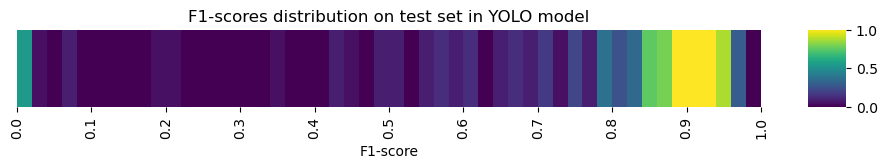

In [29]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram to represent the density of numbers
hist, bins = np.histogram(f1_scores, bins=50, range=(0, 1))

# Normalize the histogram
hist = hist / hist.max()

# Create a 2D array for the heatmap
heatmap_data = np.tile(hist, (10, 1))

# Create the plot
plt.figure(figsize=(12, 1))  # Wide and low in height
num_ticks = 11
tick_positions = np.linspace(0, heatmap_data.shape[1], num_ticks)
tick_labels = np.linspace(0, 1, num_ticks)


sns.heatmap(heatmap_data, cmap='viridis', cbar=True, xticklabels=True, yticklabels=False,cbar_kws={"shrink": 1, "aspect": 2})
plt.xticks(tick_positions, [f"{label:.1f}" for label in tick_labels])

plt.title('F1-scores distribution on test set in YOLO model')
plt.xlabel('F1-score')
#plt.ylabel('Intensity')
plt.show()

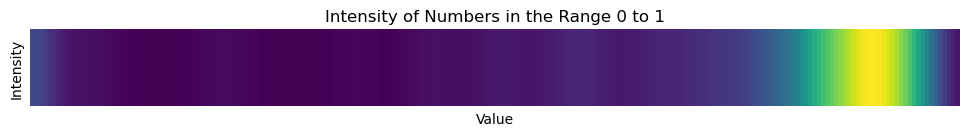

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
# Perform kernel density estimation
kde = gaussian_kde(f1_scores, bw_method=0.08)  # Adjust bw_method for smoothing
x = np.linspace(0, 1,len(f1_scores))
density = kde(x)

# Normalize the density
density = density / density.max()

# Create a 2D array for the heatmap
heatmap_data = np.tile(density, (10, 1))

# Create the plot
plt.figure(figsize=(12, 1))  # Wide and low in height
sns.heatmap(heatmap_data, cmap='viridis', cbar=False, xticklabels=False, yticklabels=False)
plt.title('Intensity of Numbers in the Range 0 to 1')
plt.xlabel('Value')
plt.ylabel('Intensity')
plt.show()

Plotting YOLO

In [ ]:
def plot_segmentation(image, mask, pred_mask,idx=""):
    
    #image = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    #mask = mask.squeeze(0).cpu().numpy()
    #pred_mask = pred_mask.squeeze(0).squeeze(0).cpu().numpy()

    ## Rescale the image to its original range (0, 255)
    #transform_mean = [0.485, 0.456, 0.406]
    #transform_std = [0.229, 0.224, 0.225]
    #image = (image * transform_std + transform_mean) * 255
    #image = image.astype(np.uint8)

    # Create an alpha channel for the mask
    alpha_mask = np.zeros_like(mask, dtype=np.float32)
    mask[mask > 0] = 1


    alpha_mask[mask > 0] = 0.5  # Adjust transparency here (0.5 for 50% transparency)
    
    alpha_pred_mask = np.zeros_like(pred_mask, dtype=np.float32)
    alpha_pred_mask[pred_mask > 0] = 0.5  # Adjust transparency here (0.5 for 50% transparency)
    
    # Plot the original image,
    fig, axes = plt.subplots(1, 1, figsize=(12, 6))
    axes.imshow(image,cmap='jet')
    axes.title.set_text(f"Input Image {idx}")
    axes.axis('off')
    # Plot the original image, ground truth mask, and predicted mask
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    
    # Original image with ground truth mask
    axes[0].imshow(image)
    axes[0].imshow(mask, cmap='jet', alpha=alpha_mask)  # Overlay mask with transparency
    axes[0].set_title("Ground Truth Mask")
    axes[0].axis('off')
    
    # Original image with predicted mask
    axes[1].imshow(image,cmap='jet')
    axes[1].imshow(pred_mask, cmap='jet', alpha=alpha_pred_mask)  # Overlay mask with transparency
    axes[1].set_title("Predicted Mask")
    axes[1].axis('off')
    fig.savefig('Yolo_bild_result.png',bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()


In [ ]:

# Example usage
from ultralytics import YOLO
trained_model=YOLO("runs/detect/train20/weights/best.pt")
#train322
import os
import torch
from train import calculate_f1
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from torchvision import transforms




test_folder = 'valid/'  # Replace with your folder path

# Create a list of image paths
image_paths = [os.path.join(test_folder, filename) 
               for filename in os.listdir(test_folder) 
               if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]  # Include desired image formats

image_paths=image_paths
test_results = trained_model(image_paths)
import json

def get_bbox_for_file_name(json_path, file_name):
    # Load the JSON file
    with open(json_path) as f:
        coco_data = json.load(f)

    # Extract relevant information
    image_id_to_file_name = {image['id']: image['file_name'] for image in coco_data['images']}
    file_name_to_image_id = {v: k for k, v in image_id_to_file_name.items()}
    annotations = coco_data['annotations']

    # Find the image ID for the specified file name
    if file_name not in file_name_to_image_id:
        raise ValueError(f"File name {file_name} not found in the dataset.")
    
    image_id = file_name_to_image_id[file_name]

    # Extract bounding boxes for the specified image ID
    bboxes = [ann['bbox'] for ann in annotations if ann['image_id'] == image_id]

    return bboxes

# Function to convert bounding boxes from (x, y, w, h) to (x_min, y_min, x_max, y_max)
def convert_bbox_format(bbox,format='min'):
    if format=='min':
        x, y, w, h = bbox
        x_min = x
        y_min = y
        x_max = x + w
        y_max = y + h
        return [x_min, y_min, x_max, y_max]
    elif format=="center":
        x_center, y_center, w, h = bbox
        x_min = x_center - w / 2
        y_min = y_center - h / 2
        x_max = x_center + w / 2
        y_max = y_center + h / 2
        return [x_min, y_min, x_max, y_max]
    else:
        raise ValueError("Invalid format. Use 'min' or 'center'.")
        
def create_bbox_mask(bbox, image_size=(640, 640)):
    mask = np.zeros(image_size, dtype=np.uint8)
    xmin, ymin, xmax, ymax = bbox
    x_min, y_min, x_max, y_max = int(xmin), int(ymin), int(xmax), int(ymax)
    mask[y_min:y_max, x_min:x_max] = 1
    return mask


json_path = "valid/_annotations.coco.json"
# return a list of Results objects
f1_scores = []

for i,test_result in enumerate(test_results): 
    if i==37:
        bbox_pred=test_result.boxes.xyxy.round().tolist()
        path_to_file=image_paths[i]
        file_name = os.path.basename(path_to_file)
        # Load the image
        image = Image.open(path_to_file)
        

        bbox_label = convert_bbox_format(get_bbox_for_file_name(json_path, file_name)[0],"min")
        #print(f"Predicted Bounding Box: {bbox_pred}")
        #print(f"Labeled Bounding Box: {bbox_label}")
        
        if bbox_pred:
            # Create masks for the labeled and predicted bounding boxes
            mask_pred = create_bbox_mask(bbox_pred[0])
            mask_label = create_bbox_mask(bbox_label)
            plot_segmentation(image,mask_label, mask_pred,idx=i )


